<a href="https://colab.research.google.com/github/Shivdutta/EIP4/blob/master/Assignment5/PersonAttrubutes121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')
!unzip -q "/content/gdrive/My Drive/hvc_data.zip"
# look for `hvc_annotations.csv` file and `resized` dir
%ls 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
gdrive/  hvc_annotations.csv  resized/  sample_data/


In [3]:
#%tensorflow_version 1.x

import cv2
import json

import numpy as np
import pandas as pd

from functools import partial
from pathlib import Path 
from tqdm import tqdm

from google.colab.patches import cv2_imshow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from keras.utils import plot_model
from keras.applications import VGG16
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, BatchNormalization, Activation, AveragePooling2D,GlobalAveragePooling2D,DepthwiseConv2D,SeparableConv2D
from keras.regularizers import l2
import os
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
import keras
import numpy as np

Using TensorFlow backend.


In [0]:
def lr_scheduler(epoch, lr):
  return round(0.004 * 1/(1 + 0.319 * epoch), 10)

In [5]:
# load annotations
#df = pd.read_csv("/content/gdrive/My Drive/assignment5_data/hvc_data.zip (Unzipped Files)/hvc_annotations.csv")
df = pd.read_csv("hvc_annotations.csv")
del df["filename"] # remove unwanted column
df.head()

,gender,imagequality,age,weight,carryingbag,footwear,emotion,bodypose,image_path
0,male,Average,35-45,normal-healthy,Grocery/Home/Plastic Bag,Normal,Neutral,Front-Frontish,resized/1.jpg
1,female,Average,35-45,over-weight,None,Normal,Angry/Serious,Front-Frontish,resized/2.jpg
2,male,Good,45-55,normal-healthy,Grocery/Home/Plastic Bag,CantSee,Neutral,Front-Frontish,resized/3.jpg
3,male,Good,45-55,normal-healthy,Daily/Office/Work Bag,Normal,Neutral,Front-Frontish,resized/4.jpg
4,female,Good,35-45,slightly-overweight,None,CantSee,Neutral,Front-Frontish,resized/5.jpg


In [0]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):

  """
  p : the probability that random erasing is performed
  s_l, s_h : minimum / maximum proportion of erased area against input image
  r_1, r_2 : minimum / maximum aspect ratio of erased area
  v_l, v_h : minimum / maximum value for erased area
  pixel_level : pixel-level randomization for erased area
  """

  def eraser(input_img):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
        return input_img

    while True:
        s = np.random.uniform(s_l, s_h) * img_h * img_w
        r = np.random.uniform(r_1, r_2)
        w = int(np.sqrt(s / r))
        h = int(np.sqrt(s * r))
        left = np.random.randint(0, img_w)
        top = np.random.randint(0, img_h)

        if left + w <= img_w and top + h <= img_h:
            break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img

  return eraser

In [7]:
# one hot encoding of labels

one_hot_df = pd.concat([
    df[["image_path"]],
    pd.get_dummies(df.gender, prefix="gender"),
    pd.get_dummies(df.imagequality, prefix="imagequality"),
    pd.get_dummies(df.age, prefix="age"),
    pd.get_dummies(df.weight, prefix="weight"),
    pd.get_dummies(df.carryingbag, prefix="carryingbag"),
    pd.get_dummies(df.footwear, prefix="footwear"),
    pd.get_dummies(df.emotion, prefix="emotion"),
    pd.get_dummies(df.bodypose, prefix="bodypose"),
], axis = 1)

one_hot_df.head().T

,0,1,2,3,4
image_path,resized/1.jpg,resized/2.jpg,resized/3.jpg,resized/4.jpg,resized/5.jpg
gender_female,0,1,0,0,1
gender_male,1,0,1,1,0
imagequality_Average,1,1,0,0,0
imagequality_Bad,0,0,0,0,0
imagequality_Good,0,0,1,1,1
age_15-25,0,0,0,0,0
age_25-35,0,0,0,0,0
age_35-45,1,1,0,0,1
age_45-55,0,0,1,1,0


In [0]:


# Label columns per attribute
_gender_cols_ = [col for col in one_hot_df.columns if col.startswith("gender")]
_imagequality_cols_ = [col for col in one_hot_df.columns if col.startswith("imagequality")]
_age_cols_ = [col for col in one_hot_df.columns if col.startswith("age")]
_weight_cols_ = [col for col in one_hot_df.columns if col.startswith("weight")]
_carryingbag_cols_ = [col for col in one_hot_df.columns if col.startswith("carryingbag")]
_footwear_cols_ = [col for col in one_hot_df.columns if col.startswith("footwear")]
_emotion_cols_ = [col for col in one_hot_df.columns if col.startswith("emotion")]
_bodypose_cols_ = [col for col in one_hot_df.columns if col.startswith("bodypose")]

class PersonDataGenerator(keras.utils.Sequence):
    """Ground truth data generator"""
    
    def __init__(self, df, batch_size=32, shuffle=True, augmentation=None):
        self.df = df
        self.batch_size=batch_size
        self.shuffle = shuffle
        self.augmentation = augmentation
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(self.df.shape[0] / self.batch_size))

    def __getitem__(self, index):
        """fetch batched images and targets"""
        batch_slice = slice(index * self.batch_size, (index + 1) * self.batch_size)
        items = self.df.iloc[batch_slice]
        image = np.stack([cv2.imread(item["image_path"]) for _, item in items.iterrows()])

        target = {
            "gender_output": items[_gender_cols_].values,
            "image_quality_output": items[_imagequality_cols_].values,
            "age_output": items[_age_cols_].values,
            "weight_output": items[_weight_cols_].values,
            "bag_output": items[_carryingbag_cols_].values,
            "pose_output": items[_bodypose_cols_].values,
            "footwear_output": items[_footwear_cols_].values,
            "emotion_output": items[_emotion_cols_].values,
        }
        return image, target

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        if self.shuffle == True:
            self.df = self.df.sample(frac=1).reset_index(drop=True)


In [9]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(one_hot_df, test_size=0.2,random_state=42)
train_df.shape, val_df.shape

((10858, 28), (2715, 28))

In [10]:
train_df

,image_path,gender_female,gender_male,imagequality_Average,imagequality_Bad,imagequality_Good,age_15-25,age_25-35,age_35-45,age_45-55,age_55+,weight_normal-healthy,weight_over-weight,weight_slightly-overweight,weight_underweight,carryingbag_Daily/Office/Work Bag,carryingbag_Grocery/Home/Plastic Bag,carryingbag_None,footwear_CantSee,footwear_Fancy,footwear_Normal,emotion_Angry/Serious,emotion_Happy,emotion_Neutral,emotion_Sad,bodypose_Back,bodypose_Front-Frontish,bodypose_Side
8482,resized/8483.jpg,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1
13504,resized/13506.jpg,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0
3206,resized/3207.jpg,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,1
1698,resized/1699.jpg,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0
761,resized/762.jpg,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5191,resized/5192.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
13418,resized/13420.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,1,0
5390,resized/5391.jpg,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0
860,resized/861.jpg,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0


In [11]:
col_names = list(one_hot_df.columns.values)
len(col_names)
i = 0
for i in range(len(col_names)):
    print(col_names[i],one_hot_df[one_hot_df[col_names[i]] == 1].shape[0])

image_path 0
gender_female 5937
gender_male 7636
imagequality_Average 7509
imagequality_Bad 2240
imagequality_Good 3824
age_15-25 2494
age_25-35 5411
age_35-45 3435
age_45-55 1490
age_55+ 743
weight_normal-healthy 8628
weight_over-weight 891
weight_slightly-overweight 3196
weight_underweight 858
carryingbag_Daily/Office/Work Bag 4603
carryingbag_Grocery/Home/Plastic Bag 1321
carryingbag_None 7649
footwear_CantSee 5028
footwear_Fancy 2507
footwear_Normal 6038
emotion_Angry/Serious 1500
emotion_Happy 1609
emotion_Neutral 9660
emotion_Sad 804
bodypose_Back 2207
bodypose_Front-Frontish 8383
bodypose_Side 2983


In [0]:
# create train and validation data generators

train_gen = PersonDataGenerator(train_df, 
                                batch_size=32, 
                                augmentation=ImageDataGenerator(
                                    rescale=1./255,
                                    featurewise_center=True,
                                    featurewise_std_normalization=True,                                 
                                    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
                                ))
valid_gen = PersonDataGenerator(val_df, batch_size=32, shuffle=False,
                                augmentation=ImageDataGenerator(
                                    rescale=1./255,
                                    featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    preprocessing_function=get_random_eraser(v_l=0, v_h=1)
                                ))


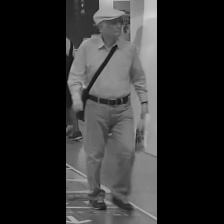

type:: <class 'numpy.ndarray'>


In [13]:
# To check if images are getting read correctly
from google.colab.patches import cv2_imshow
img = cv2.imread('resized/4.jpg',0)
cv2_imshow(img)
print('type::',type(img))

In [0]:
# get number of output units from data
images, targets = next(iter(train_gen))
num_units = { k.split("_output")[0]:v.shape[1] for k, v in targets.items()}

In [0]:
n = 2

# Model version
# Orig paper: version = 1 (ResNet v1), Improved ResNet: version = 2 (ResNet v2)
version = 2

# Computed depth from supplied model parameter n
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

In [0]:
def resnet_layer(inputs,
                 num_filters=64,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = SeparableConv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

In [0]:
def resnet_v2(input_shape, depth, num_classes=10):
    """ResNet Version 2 Model builder [b]

    Stacks of (1 x 1)-(3 x 3)-(1 x 1) BN-ReLU-Conv2D or also known as
    bottleneck layer
    First shortcut connection per layer is 1 x 1 Conv2D.
    Second and onwards shortcut connection is identity.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filter maps is
    doubled. Within each stage, the layers have the same number filters and the
    same filter map sizes.
    Features maps sizes:
    conv1  : 32x32,  16
    stage 0: 32x32,  64
    stage 1: 16x16, 128
    stage 2:  8x8,  256

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 9 != 0:
        raise ValueError('depth should be 9n+2 (eg 56 or 110 in [b])')
    # Start model definition.
    num_filters_in = 16
    num_res_blocks = int((depth - 2) / 9)

    inputs = Input(shape=input_shape)
    # v2 performs Conv2D with BN-ReLU on input before splitting into 2 paths
    x = resnet_layer(inputs=inputs,
                     num_filters=num_filters_in,
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage in range(6):
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=1)(x)
    #y = Flatten()(x)
    y = (x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model














Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 224, 224, 16) 91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________

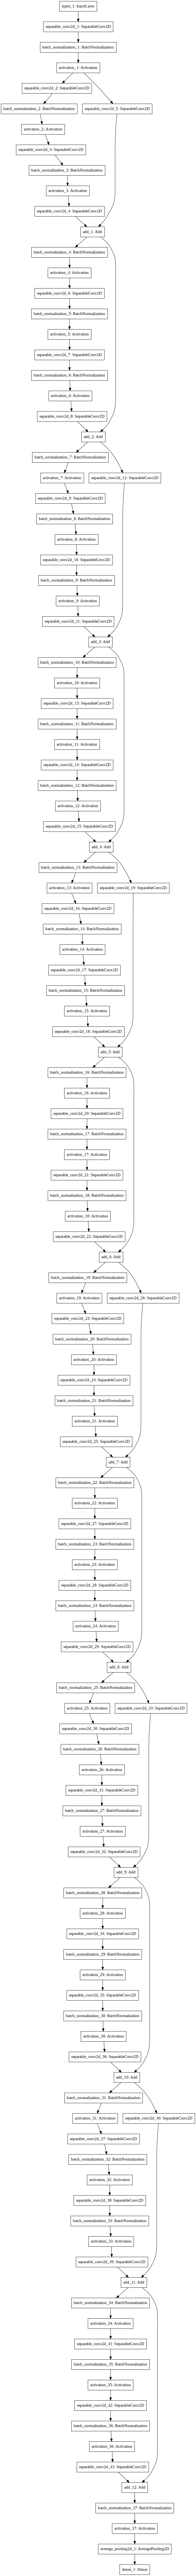

In [18]:
input_shape = (224, 224, 3)
resnet_v2_x1 = resnet_v2(input_shape=input_shape, depth=depth)
'''model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['accuracy'])'''
resnet_v2_x1.summary()
print(model_type)
from keras.utils import plot_model
plot_model(resnet_v2_x1)

In [19]:
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/saved models/'
#model_name = 'assign5_%s_model.{epoch:03d}.h5' % model_type
model_name = 'assign5_resnet50_D_i1_1.{epoch:03d}.h5'

print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

print(filepath)

/content/gdrive/My Drive/saved models/
/content/gdrive/My Drive/saved models/assign5_resnet50_D_i1_1.{epoch:03d}.h5


In [0]:
# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_scheduler)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

In [21]:
backbone = resnet_v2_x1
print("Inputs : ", backbone.input)
neck = backbone.output
neck = Flatten(name="flatten")(neck)
#neck = GlobalAveragePooling2D(name="flatten")(neck)
neck = Dense(512, activation="relu")(neck)

def build_tower(in_layer,dropout1,dense1,dropout2,dense2,act2=None):
    head = Dropout(dropout1)(in_layer)
    head = Dense(dense1, activation="relu")(head)
    head = Dropout(dropout2)(head)
    head = Dense(dense2, activation=act2)(head)
    return head

def build_tower02(in_layer,dropout1,dense1,act2=None):
    head = Dropout(dropout1)(in_layer)
    head = Dense(dense1, activation=act2)(head)
    return head

def build_head(name, activator,in_layer):
    return Dense(
        num_units[name], activation=activator, name=f"{name}_output"
    )(in_layer)

Inputs :  Tensor("input_1:0", shape=(?, 224, 224, 3), dtype=float32)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_1 (SeparableCo (None, 224, 224, 16) 91          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 224, 224, 16) 64          separable_conv2d_1[0][0]         
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 224, 224, 16) 0           batch_norma

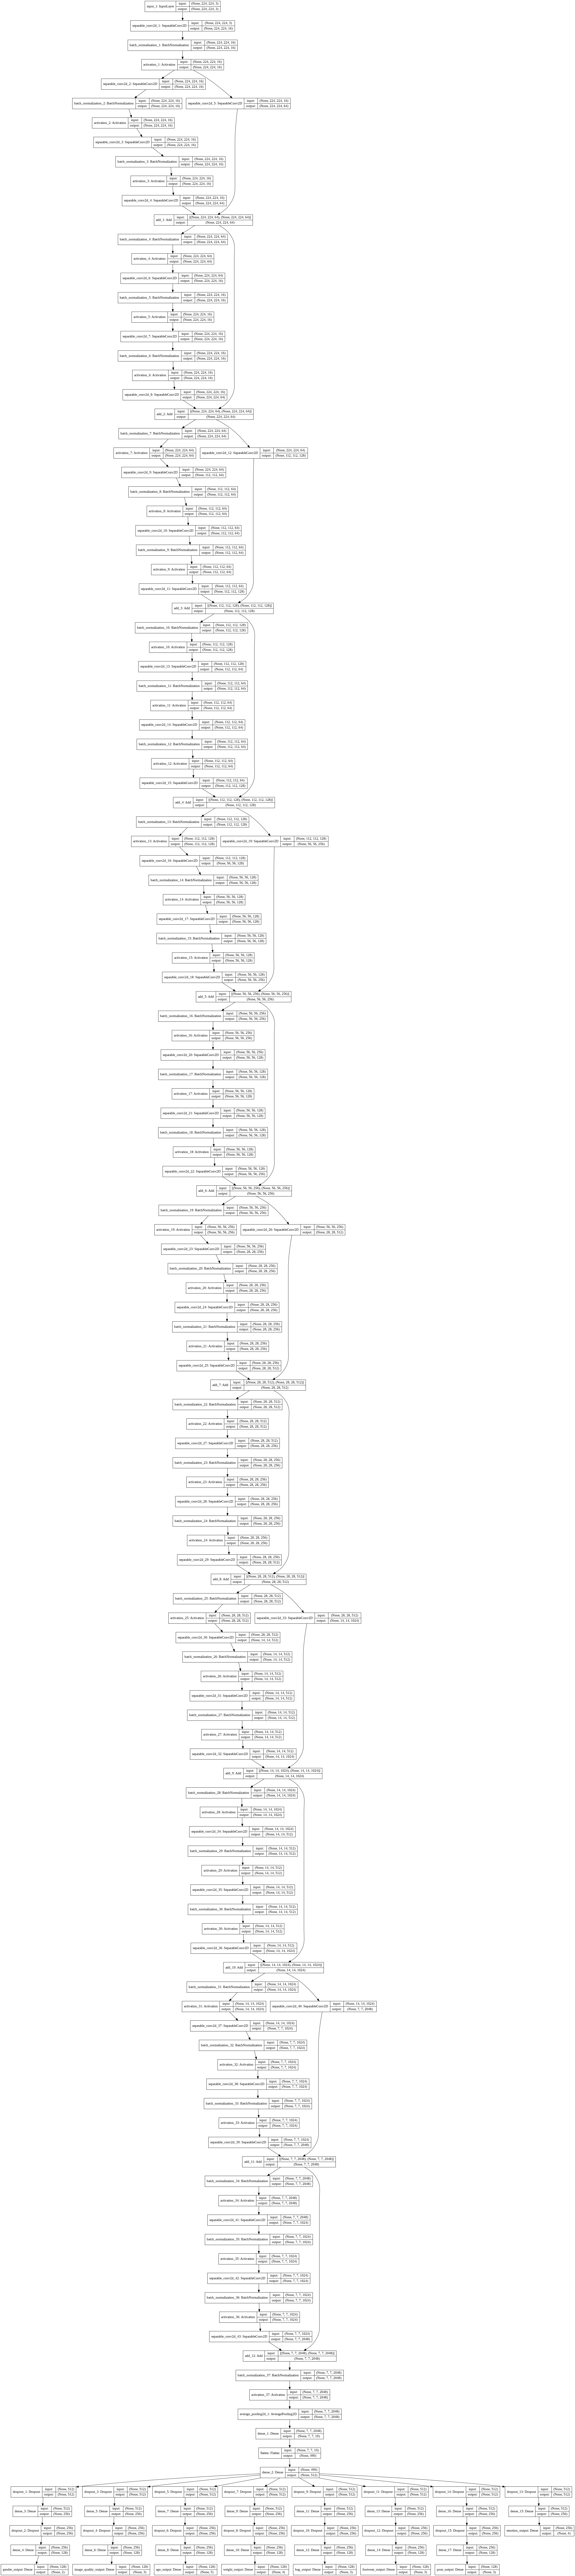

In [22]:
gender = build_head("gender", "softmax", build_tower(neck,dropout1=0.25,dense1=256,dropout2=0.2,dense2=128))  #gender is binary classification
image_quality = build_head("image_quality", "sigmoid",build_tower(neck,dropout1=0.2,dense1=256,dropout2=0.1,dense2=128)) # image is multi-class single label, can be either good, avg or bad
age = build_head("age", "sigmoid",build_tower(neck,dropout1=0.2,dense1=256,dropout2=0.1,dense2=128))  # Age is regression to arbitrary value but here we are didving to groups like 15-25, 25-35, hence multi-class single label
weight = build_head("weight", "sigmoid",build_tower(neck,dropout1=0.2,dense1=256,dropout2=0.1,dense2=128)) # weight is multi-class, single label as it can healthy, over or under
bag = build_head("bag", "sigmoid",build_tower(neck,dropout1=0.2,dense1=256,dropout2=0.1,dense2=128))  # bag is multi-class, single label 
footwear = build_head("footwear","softmax", build_tower(neck,dropout1=0.25,dense1=256,dropout2=0.2,dense2=128))  # multi-class, single label 
emotion = build_head("emotion", "sigmoid", build_tower02(neck,dropout1=0.2,dense1=256))  # multi-class, single label 
pose = build_head("pose", "sigmoid",build_tower(neck,dropout1=0.2,dense1=256,dropout2=0.1,dense2=128)) # multi-class, single label

model = Model(
    inputs=backbone.input, 
    outputs=[gender, image_quality, age, weight, bag, footwear, pose, emotion]
)
model.summary()
from keras.utils import plot_model
plot_model(model, show_shapes=True,to_file='model.png')

In [0]:
# freeze backbone
#for layer in backbone.layers:
#	layer.trainable = False

In [0]:
losses = {
 	"gender_output": "categorical_crossentropy",
 	"image_quality_output": "binary_crossentropy",
 	"age_output": "binary_crossentropy",
 	"weight_output": "binary_crossentropy",
  "bag_output": "binary_crossentropy",
 	"emotion_output": "binary_crossentropy",
 	"pose_output": "binary_crossentropy",
  "footwear_output": "binary_crossentropy",
 }

loss_weights = {"gender_output": 50, "image_quality_output": 20, "age_output": 10.0,
                "weight_output":10,"bag_output":30,"emotion_output":10.0,"pose_output":20,"footwear_output":30}
opt = SGD(lr=0.001, momentum=0.9,decay=1e-6, nesterov=True,clipnorm=1.)

# Model Compile

In [61]:
model.compile(
    optimizer=opt,
    #loss="binary_crossentropy", 
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
separable_conv2d_44 (SeparableC (None, 224, 224, 16) 91          input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_38 (BatchNo (None, 224, 224, 16) 64          separable_conv2d_44[0][0]        
__________________________________________________________________________________________________
activation_38 (Activation)      (None, 224, 224, 16) 0           batch_normalization_38[0][0]     
____________________________________________________________________________________________

In [0]:
"""model.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=50,
    verbose=1,
    callbacks=callbacks)"""



Epoch 1/50
339/339 [==============================] - 513s 2s/step - loss: 112.2177 - gender_output_loss: 0.6864 - image_quality_output_loss: 0.6160 - age_output_loss: 0.6263 - weight_output_loss: 0.6001 - bag_output_loss: 0.5852 - footwear_output_loss: 0.6134 - pose_output_loss: 0.5858 - emotion_output_loss: 0.5639 - gender_output_acc: 0.5634 - image_quality_output_acc: 0.6810 - age_output_acc: 0.6913 - weight_output_acc: 0.7465 - bag_output_acc: 0.6967 - footwear_output_acc: 0.6652 - pose_output_acc: 0.7196 - emotion_output_acc: 0.7954 - val_loss: 105.9861 - val_gender_output_loss: 0.6873 - val_image_quality_output_loss: 0.5732 - val_age_output_loss: 0.5259 - val_weight_output_loss: 0.4864 - val_bag_output_loss: 0.5489 - val_footwear_output_loss: 0.6048 - val_pose_output_loss: 0.5512 - val_emotion_output_loss: 0.4403 - val_gender_output_acc: 0.5536 - val_image_quality_output_acc: 0.7076 - val_age_output_acc: 0.8000 - val_weight_output_acc: 0.8231 - val_bag_output_acc: 0.7071 - val_

In [0]:
resnet_v2_x2= keras.models.load_model("/content/gdrive/My Drive/saved models/assign5_resnet50_D_i1_1.018.h5")

In [25]:
results = resnet_v2_x2.evaluate_generator(train_gen, verbose=1)
dict(zip(resnet_v2_x2.metrics_names, results))

339/339 [==============================] - 65s 193ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.45584328055030127,
 'bag_output_acc': 0.7097468224950244,
 'bag_output_loss': 0.5367527539047872,
 'emotion_output_acc': 0.8561946902654868,
 'emotion_output_loss': 0.3851448813107161,
 'footwear_output_acc': 0.7236049859221354,
 'footwear_output_loss': 0.5455049976135073,
 'gender_output_acc': 0.7426253687315634,
 'gender_output_loss': 0.5189562635963294,
 'image_quality_output_acc': 0.7007436281108574,
 'image_quality_output_loss': 0.5750378824792429,
 'loss': 93.40563507980302,
 'pose_output_acc': 0.7456981513352521,
 'pose_output_loss': 0.5428895852734558,
 'weight_output_acc': 0.8167404129793511,
 'weight_output_loss': 0.4221658331278854}

In [26]:
results = resnet_v2_x2.evaluate_generator(valid_gen, verbose=1)
dict(zip(resnet_v2_x2.metrics_names, results))

84/84 [==============================] - 14s 169ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.45655539099659237,
 'bag_output_acc': 0.7078373212189901,
 'bag_output_loss': 0.5390548471893583,
 'emotion_output_acc': 0.8537946428571429,
 'emotion_output_loss': 0.3887459924888043,
 'footwear_output_acc': 0.7130456545523235,
 'footwear_output_loss': 0.554359146172092,
 'gender_output_acc': 0.6808035714285714,
 'gender_output_loss': 0.5933991560623759,
 'image_quality_output_acc': 0.7075893055825007,
 'image_quality_output_loss': 0.5706621227519852,
 'loss': 97.44989013671875,
 'pose_output_acc': 0.7433035927159446,
 'pose_output_loss': 0.5462085058291754,
 'weight_output_acc': 0.8231026785714286,
 'weight_output_loss': 0.4187086245843342}

In [66]:
import os
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/saved models/'
#model_name = 'assign5_%s_model.{epoch:03d}.h5' % model_type
model_name2 = 'assign5_resnet50_D_i2_1.{epoch:03d}.h5'

print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath2 = os.path.join(save_dir, model_name2)

print(filepath2)

losses = {
 	"gender_output": "categorical_crossentropy",
 	"image_quality_output": "binary_crossentropy",
 	"age_output": "binary_crossentropy",
 	"weight_output": "binary_crossentropy",
  "bag_output": "binary_crossentropy",
 	"emotion_output": "binary_crossentropy",
 	"pose_output": "binary_crossentropy",
  "footwear_output": "binary_crossentropy",
 }

loss_weights = {"gender_output": 50, "image_quality_output": 20, "age_output": 10.0,
                "weight_output":10,"bag_output":30,"emotion_output":10.0,"pose_output":20,"footwear_output":30}
opt = SGD(lr=0.001, momentum=0.9,decay=1e-6, nesterov=True,clipnorm=1.)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint2 = ModelCheckpoint(filepath=filepath2,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler2 = LearningRateScheduler(lr_scheduler)

lr_reducer2 = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks2 = [checkpoint2, lr_reducer2, lr_scheduler2]

resnet_v2_x2.compile(
    optimizer=opt,
    #loss="binary_crossentropy", 
    loss=losses, 
    loss_weights=loss_weights, 
    metrics=["accuracy"]
)

resnet_v2_x2.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=4, 
    epochs=50,
    verbose=1,
    callbacks=callbacks2)

/content/gdrive/My Drive/saved models/
/content/gdrive/My Drive/saved models/assign5_resnet50_D_i2_1.{epoch:03d}.h5
Epoch 1/50
339/339 [==============================] - 535s 2s/step - loss: 97.3871 - gender_output_loss: 0.5868 - image_quality_output_loss: 0.5763 - age_output_loss: 0.4583 - weight_output_loss: 0.4240 - bag_output_loss: 0.5415 - footwear_output_loss: 0.5556 - pose_output_loss: 0.5463 - emotion_output_loss: 0.3859 - gender_output_acc: 0.6846 - image_quality_output_acc: 0.6988 - age_output_acc: 0.7998 - weight_output_acc: 0.8167 - bag_output_acc: 0.7106 - footwear_output_acc: 0.7167 - pose_output_acc: 0.7456 - emotion_output_acc: 0.8563 - val_loss: 98.9857 - val_gender_output_loss: 0.6217 - val_image_quality_output_loss: 0.5705 - val_age_output_loss: 0.4561 - val_weight_output_loss: 0.4182 - val_bag_output_loss: 0.5416 - val_footwear_output_loss: 0.5562 - val_pose_output_loss: 0.5467 - val_emotion_output_loss: 0.3882 - val_gender_output_acc: 0.6663 - val_image_quality_out

In [24]:
resnet_v2_x3= keras.models.load_model("/content/gdrive/My Drive/saved models/assign5_resnet50_D_i2_1.007.h5")



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




In [25]:
results = resnet_v2_x3.evaluate_generator(train_gen, verbose=1)
dict(zip(resnet_v2_x3.metrics_names, results))

339/339 [==============================] - 65s 191ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.45486778987895776,
 'bag_output_acc': 0.723727897205184,
 'bag_output_loss': 0.5277574641690493,
 'emotion_output_acc': 0.856148598820059,
 'emotion_output_loss': 0.38431690299229637,
 'footwear_output_acc': 0.7353429405738471,
 'footwear_output_loss': 0.5303470121372414,
 'gender_output_acc': 0.8142514749262537,
 'gender_output_loss': 0.42164618915337027,
 'image_quality_output_acc': 0.7009587199990377,
 'image_quality_output_loss': 0.5747014372046366,
 'loss': 87.78585286548356,
 'pose_output_acc': 0.7458210620908259,
 'pose_output_loss': 0.5431485488175642,
 'weight_output_acc': 0.8166943215339233,
 'weight_output_loss': 0.4211562329513133}

In [31]:
results = resnet_v2_x3.evaluate_generator(valid_gen, verbose=1)
dict(zip(resnet_v2_x3.metrics_names, results))

84/84 [==============================] - 14s 168ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.4547815202247529,
 'bag_output_acc': 0.7208581566810608,
 'bag_output_loss': 0.5330743956423941,
 'emotion_output_acc': 0.8537946428571429,
 'emotion_output_loss': 0.3872516243940308,
 'footwear_output_acc': 0.7282986342906952,
 'footwear_output_loss': 0.5402462716613498,
 'gender_output_acc': 0.6975446428571429,
 'gender_output_loss': 0.971062374256906,
 'image_quality_output_acc': 0.7085813688380378,
 'image_quality_output_loss': 0.5700327778855959,
 'loss': 115.67479760306222,
 'pose_output_acc': 0.7433035927159446,
 'pose_output_loss': 0.5466928343687739,
 'weight_output_acc': 0.8231026785714286,
 'weight_output_loss': 0.41672158276750926}

In [30]:
import os
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/saved models/'
#model_name = 'assign5_%s_model.{epoch:03d}.h5' % model_type
model_name3 = 'assign5_resnet50_D_i3_1.{epoch:03d}.h5'

print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath3 = os.path.join(save_dir, model_name3)

print(filepath3)

losses = {
 	"gender_output": "categorical_crossentropy",
 	"image_quality_output": "binary_crossentropy",
 	"age_output": "binary_crossentropy",
 	"weight_output": "binary_crossentropy",
  "bag_output": "binary_crossentropy",
 	"emotion_output": "binary_crossentropy",
 	"pose_output": "binary_crossentropy",
  "footwear_output": "binary_crossentropy",
 }

loss_weights3 = {"gender_output": 50, "image_quality_output": 20, "age_output": 10.0,
                "weight_output":10,"bag_output":30,"emotion_output":10.0,"pose_output":20,"footwear_output":30}
opt = SGD(lr=0.001, momentum=0.9,decay=1e-6, nesterov=True,clipnorm=1.)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint3 = ModelCheckpoint(filepath=filepath3,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler3 = LearningRateScheduler(lr_scheduler)

lr_reducer3 = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks3 = [checkpoint3, lr_reducer3, lr_scheduler3]

resnet_v2_x3.compile(
    optimizer=opt,
    #loss="binary_crossentropy", 
    loss=losses, 
    loss_weights=loss_weights3, 
    metrics=["accuracy"]
)

resnet_v2_x3.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=25,
    verbose=1,
    callbacks=callbacks3)

/content/gdrive/My Drive/saved models/
/content/gdrive/My Drive/saved models/assign5_resnet50_D_i3_1.{epoch:03d}.h5
Epoch 1/25
339/339 [==============================] - 510s 2s/step - loss: 92.9859 - gender_output_loss: 0.5129 - image_quality_output_loss: 0.5779 - age_output_loss: 0.4571 - weight_output_loss: 0.4232 - bag_output_loss: 0.5332 - footwear_output_loss: 0.5405 - pose_output_loss: 0.5454 - emotion_output_loss: 0.3859 - gender_output_acc: 0.7462 - image_quality_output_acc: 0.6982 - age_output_acc: 0.8000 - weight_output_acc: 0.8165 - bag_output_acc: 0.7224 - footwear_output_acc: 0.7285 - pose_output_acc: 0.7457 - emotion_output_acc: 0.8562 - val_loss: 97.9507 - val_gender_output_loss: 0.6055 - val_image_quality_output_loss: 0.5718 - val_age_output_loss: 0.4555 - val_weight_output_loss: 0.4172 - val_bag_output_loss: 0.5359 - val_footwear_output_loss: 0.5546 - val_pose_output_loss: 0.5460 - val_emotion_output_loss: 0.3881 - val_gender_output_acc: 0.6927 - val_image_quality_out

In [0]:
resnet_v2_x4= keras.models.load_model("/content/gdrive/My Drive/saved models/assign5_resnet50_D_i3_1.002.h5")

In [34]:
results = resnet_v2_x4.evaluate_generator(train_gen, verbose=1)
dict(zip(resnet_v2_x3.metrics_names, results))

339/339 [==============================] - 62s 182ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.4545388986579085,
 'bag_output_acc': 0.7254793716039629,
 'bag_output_loss': 0.5285887085231005,
 'emotion_output_acc': 0.8563790560471977,
 'emotion_output_loss': 0.3839289491067594,
 'footwear_output_acc': 0.7361725871190209,
 'footwear_output_loss': 0.5294903428856954,
 'gender_output_acc': 0.7609697640117994,
 'gender_output_loss': 0.49204852803442684,
 'image_quality_output_acc': 0.701112360201754,
 'image_quality_output_loss': 0.5750143336335466,
 'loss': 91.29189156501343,
 'pose_output_acc': 0.7458210620908259,
 'pose_output_loss': 0.5426725615969802,
 'weight_output_acc': 0.8168325958702065,
 'weight_output_loss': 0.42086771174518056}

In [35]:
results = resnet_v2_x4.evaluate_generator(valid_gen, verbose=1)
dict(zip(resnet_v2_x3.metrics_names, results))

84/84 [==============================] - 14s 171ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.45504375653607504,
 'bag_output_acc': 0.7181299790030434,
 'bag_output_loss': 0.5325718507880256,
 'emotion_output_acc': 0.8537946428571429,
 'emotion_output_loss': 0.3877394117769741,
 'footwear_output_acc': 0.7281746225697654,
 'footwear_output_loss': 0.537113080067294,
 'gender_output_acc': 0.7012648809523809,
 'gender_output_loss': 0.5907644753654798,
 'image_quality_output_acc': 0.7077133144651141,
 'image_quality_output_loss': 0.5710221727689108,
 'loss': 96.5767883119129,
 'pose_output_acc': 0.7433035927159446,
 'pose_output_loss': 0.5461914876387233,
 'weight_output_acc': 0.8231026785714286,
 'weight_output_loss': 0.4175911694765091}

In [38]:
import os
# Prepare model model saving directory.
#save_dir = os.path.join(os.getcwd(), 'saved_models')
save_dir = '/content/gdrive/My Drive/saved models/'
#model_name = 'assign5_%s_model.{epoch:03d}.h5' % model_type
model_name4 = 'assign5_resnet50_D_i4_1.{epoch:03d}.h5'

print(save_dir)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath4 = os.path.join(save_dir, model_name4)

print(filepath4)

losses = {
 	"gender_output": "categorical_crossentropy",
 	"image_quality_output": "binary_crossentropy",
 	"age_output": "binary_crossentropy",
 	"weight_output": "binary_crossentropy",
  "bag_output": "binary_crossentropy",
 	"emotion_output": "binary_crossentropy",
 	"pose_output": "binary_crossentropy",
  "footwear_output": "binary_crossentropy",
 }

loss_weights4 = {"gender_output": 50, "image_quality_output": 20, "age_output": 10.0,
                "weight_output":10,"bag_output":30,"emotion_output":10.0,"pose_output":20,"footwear_output":30}
opt = SGD(lr=0.001, momentum=0.9,decay=1e-6, nesterov=True,clipnorm=1.)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint4 = ModelCheckpoint(filepath=filepath4,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

lr_scheduler4 = LearningRateScheduler(lr_scheduler)

lr_reducer4 = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks4 = [checkpoint4, lr_reducer4, lr_scheduler4]

resnet_v2_x4.compile(
    optimizer=opt,
    #loss="binary_crossentropy", 
    loss=losses, 
    loss_weights=loss_weights3, 
    metrics=["accuracy"]
)

resnet_v2_x4.fit_generator(
    generator=train_gen,
    validation_data=valid_gen,
    use_multiprocessing=True,
    workers=6, 
    epochs=20,
    verbose=1,
    callbacks=callbacks4)

/content/gdrive/My Drive/saved models/
/content/gdrive/My Drive/saved models/assign5_resnet50_D_i4_1.{epoch:03d}.h5
Epoch 1/20
339/339 [==============================] - 521s 2s/step - loss: 91.4383 - gender_output_loss: 0.4847 - image_quality_output_loss: 0.5767 - age_output_loss: 0.4568 - weight_output_loss: 0.4236 - bag_output_loss: 0.5317 - footwear_output_loss: 0.5379 - pose_output_loss: 0.5461 - emotion_output_loss: 0.3857 - gender_output_acc: 0.7656 - image_quality_output_acc: 0.7001 - age_output_acc: 0.8000 - weight_output_acc: 0.8164 - bag_output_acc: 0.7235 - footwear_output_acc: 0.7301 - pose_output_acc: 0.7454 - emotion_output_acc: 0.8562 - val_loss: 98.6553 - val_gender_output_loss: 0.6255 - val_image_quality_output_loss: 0.5710 - val_age_output_loss: 0.4549 - val_weight_output_loss: 0.4168 - val_bag_output_loss: 0.5386 - val_footwear_output_loss: 0.5436 - val_pose_output_loss: 0.5452 - val_emotion_output_loss: 0.3874 - val_gender_output_acc: 0.6886 - val_image_quality_out

In [39]:
results = resnet_v2_x4.evaluate_generator(train_gen, verbose=1)
dict(zip(resnet_v2_x3.metrics_names, results))

339/339 [==============================] - 58s 171ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.45391244135775044,
 'bag_output_acc': 0.7538102436206334,
 'bag_output_loss': 0.5033089420964233,
 'emotion_output_acc': 0.856148598820059,
 'emotion_output_loss': 0.3831967161995823,
 'footwear_output_acc': 0.7598328611492056,
 'footwear_output_loss': 0.49472062707298975,
 'gender_output_acc': 0.9934550147492626,
 'gender_output_loss': 0.03394086495904488,
 'image_quality_output_acc': 0.7026180137047725,
 'image_quality_output_loss': 0.5735668908354103,
 'loss': 66.55120337607235,
 'pose_output_acc': 0.7458825178202626,
 'pose_output_loss': 0.5431619292691042,
 'weight_output_acc': 0.8167865044247787,
 'weight_output_loss': 0.420760500044246}

In [44]:
results = resnet_v2_x4.evaluate_generator(valid_gen, verbose=1)
dict(zip(resnet_v2_x3.metrics_names, results))

84/84 [==============================] - 14s 171ms/step


{'age_output_acc': 0.800000011920929,
 'age_output_loss': 0.45471820838394617,
 'bag_output_acc': 0.7216022007522129,
 'bag_output_loss': 0.5328253230878285,
 'emotion_output_acc': 0.8537946428571429,
 'emotion_output_loss': 0.38752382301858496,
 'footwear_output_acc': 0.7275545824141729,
 'footwear_output_loss': 0.5337334853552637,
 'gender_output_acc': 0.6990327380952381,
 'gender_output_loss': 0.9930417569620269,
 'image_quality_output_acc': 0.7082093443189349,
 'image_quality_output_loss': 0.5692407322071847,
 'loss': 116.55328905014764,
 'pose_output_acc': 0.7433035927159446,
 'pose_output_loss': 0.5466791980323338,
 'weight_output_acc': 0.8231026785714286,
 'weight_output_loss': 0.41636188328266144}